In [1]:
import torch
torch.cuda.is_available()

True

In [14]:
import time
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
#from datasets import load_dataset
import soundfile as sf
import torch
import streamlit as st
from pyannote.audio import Pipeline, Inference
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from librosa.display import waveplot

def timestamp(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return "%d:%02d:%06.3f" % (hour, minutes, seconds)

def dia(audio):
    model = Inference("pyannote/speaker-diarization")
    diarization = model(audio)
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        st.write(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

def diarization(audio):
    pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization")

    # apply pretrained pipeline
    diarization = pipeline(audio)

    temp_start = []
    temp_end = []
    temp_speaker = []
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        #st.write(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")
        temp_start.append(turn.start)
        temp_end.append(turn.end)
        temp_speaker.append(speaker)
    return pd.DataFrame(list(zip(temp_start,temp_end,temp_speaker)),columns=["Start","End","Speaker"])

def generate_transcript_dia(audio, sr, dia_df):
    print("\nTRANSCRIPT------------------")
    margin  = int(0.1*sr)
    transcripts = []
    for index, row in dia_df.iterrows():
        temp_string = asr(audio[int(row["Start"]*sr)-margin:int(row["End"]*sr)+margin],sr)
        print("**"+row["Speaker"]+"** "+timestamp(row["Start"])+" - "+timestamp(row["End"])+" ")
        print(temp_string)
        transcripts.append(temp_string)
    dia_df["Transcript"] = transcripts
    return dia_df

def asr(audio, sr):
    
    split_val = 15
    (len(audio)/sr)/split_val

    fig = plt.figure(figsize=(10,1), dpi=150)
    librosa.display.waveshow(audio, sr=sr, color="red")
    st.pyplot(fig)

    non_silent_interval = librosa.effects.split(audio, top_db=10, hop_length=1000)
    st.write(len(audio))
    st.write(non_silent_interval)
    just_voice = audio[non_silent_interval[0][0]-50:non_silent_interval[0][1]+50]
    for i in range(1,len(non_silent_interval)):
        just_voice = np.concatenate((just_voice,audio[non_silent_interval[i][0]:non_silent_interval[i][1]]))
    
    
    fig = plt.figure(figsize=(10,1), dpi=150)
    librosa.display.waveshow(just_voice, sr=sr, color="red")
    st.pyplot(fig)


    return asr_transcript(audio,sr)

def asr_transcript(audio, sr):

    # tokenize
    input_values = processor(audio, return_tensors="pt", padding="longest", sampling_rate=sr).input_values  # Batch size 1
 
    # retrieve logits (non-normalised prediction values)
    logits = model(input_values).logits
 
    # take argmax and decode
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]

    return transcription

In [11]:
def load_W2V2():
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")
    model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h-lv60-self")
    return processor, model

processor, model = load_W2V2()

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2022-02-21 13:47:36.063 Fetch hyperparams.yaml: Using existing file/symlink in C:\Users\mikea\.cache\torch\pyannote\speechbrain\hyperparams.yaml.
2022-02-21 13:47:36.064 Fetch custom.py: Delegating to Huggingface hub, source speechbrain/spkrec-ecapa-voxceleb.
2022-02-21 13:47:36.694 Fetch embedding_model.ckpt: Using existing file/symlink in C:\Users\mikea\.cache\torch\pyannote\speechbrain\embedding_model.ckpt.
2022-02-21 13:47:36.695 Fetch mean_var_norm_emb.ckpt: Using existing file/symlink in C:\Users\mikea\.cache\torch\pyannote\speechbrain\mean_var_norm_emb.ckpt.
2022-02-21 13:47:36.696 Fetch classifier.ckpt: Using existing file/symlink in C:\Users\mikea\.cache\torch\pyannote\speechbrain\classifier.ckpt.
2022-02-21 13:47:36.697 Fetch label_encoder.txt: Using existing file/symlink in C:\Users\mikea\.cache\torch\pyannote\speechbrain\label_encoder.ckpt.
2022-02-21 13:47:36.697 Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder


**SPEAKER_00** 0:00:01.135 - 0:00:17.032 
THE FIRST TIME I MET STEPHEN HAWKING I WAS STRUCK BY HIS EXTRAORDINARY POWER AND HIS VULNERABILITY THE DETERMINED LOOK IN HIS EYES COUPLED WITH HIS IMMOBILE BODY WAS FAMILIAR TO ME FROM MY RESEARCH
**SPEAKER_00** 0:00:17.437 - 0:00:25.840 
I HAD RECENTLY BEEN ENGAGED TO PLAY THE ROLE OF STEPHEN IN THE THEORY OF EVERYTHING AND HAD SPENT SEVERAL MONTHS
**SPEAKER_00** 0:00:26.110 - 0:00:27.477 
STUDYING HIS WORK
**SPEAKER_00** 0:00:27.848 - 0:00:29.772 
AND THE NATURE OF HIS DISABILITY
**SPEAKER_00** 0:00:30.228 - 0:00:31.797 
ATTEMPTING TO UNDERSTAND
**SPEAKER_00** 0:00:32.101 - 0:00:33.400 
HOW TO USE MY BODY
**SPEAKER_00** 0:00:33.738 - 0:00:47.069 
TO EXPRESS THE PASSAGE OF MOTOR NEURONE DISEASE OVER TIME AND YET WHEN I FINALLY MET STEPHEN THE IKIN THE SCIENTIST OF PHENOMOMENAL TALENT WHOSE MAIN COMMUNICATION
**SPEAKER_00** 0:00:47.356 - 0:00:49.313 
WAS THROUGH A COMPUTERZED VOICE
**SPEAKER_00** 0:00:49.600 - 0:00:53.077 
ALONG WITH A PAIR OF

,Start,End,Speaker,Transcript
0,1.135312,17.031562,SPEAKER_00,THE FIRST TIME I MET STEPHEN HAWKING I WAS STR...
1,17.436563,25.840313,SPEAKER_00,I HAD RECENTLY BEEN ENGAGED TO PLAY THE ROLE O...
2,26.110313,27.477188,SPEAKER_00,STUDYING HIS WORK
3,27.848438,29.772188,SPEAKER_00,AND THE NATURE OF HIS DISABILITY
4,30.227813,31.797188,SPEAKER_00,ATTEMPTING TO UNDERSTAND
5,32.100938,33.400313,SPEAKER_00,HOW TO USE MY BODY
6,33.737813,47.069063,SPEAKER_00,TO EXPRESS THE PASSAGE OF MOTOR NEURONE DISEAS...
7,47.355938,49.313438,SPEAKER_00,WAS THROUGH A COMPUTERZED VOICE
8,49.600313,53.076563,SPEAKER_00,ALONG WITH A PAIR OF EXCEPTIONALLY EXPRESSIVE ...
9,53.549063,54.409688,SPEAKER_00,I WAS FLOORED


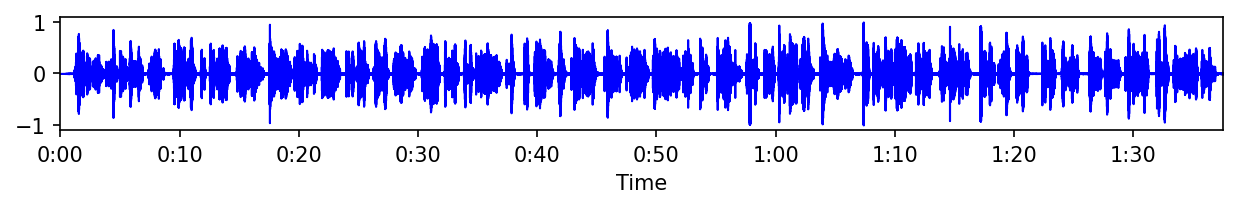

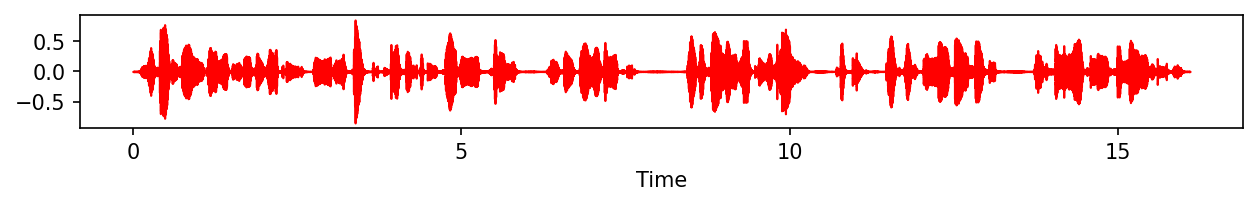

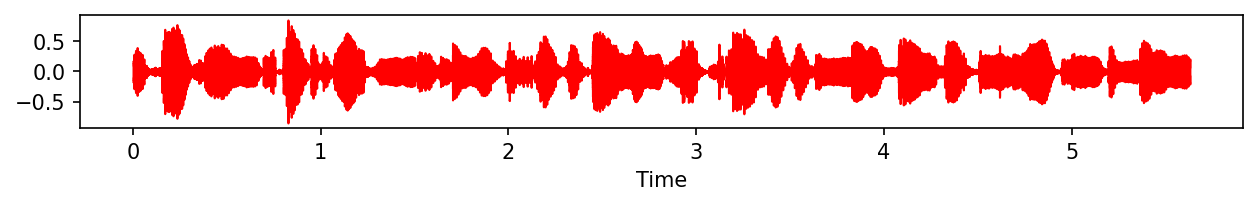

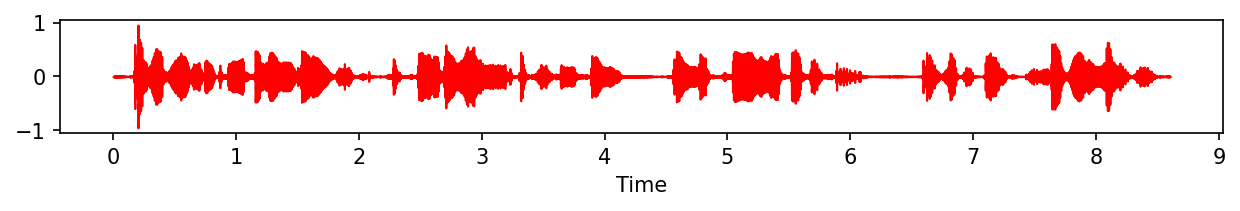

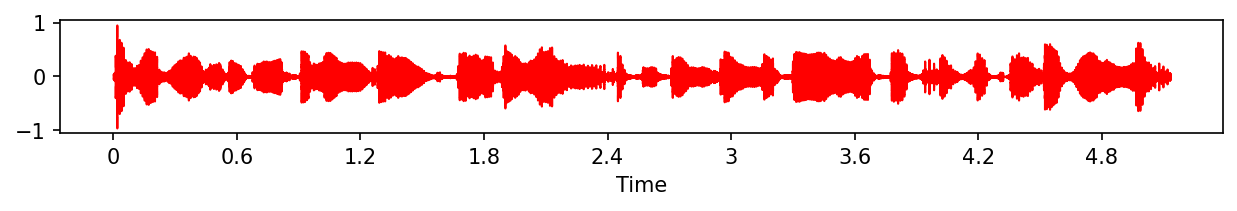

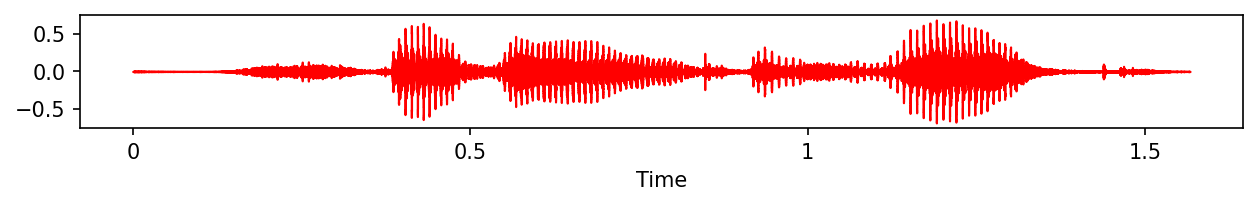

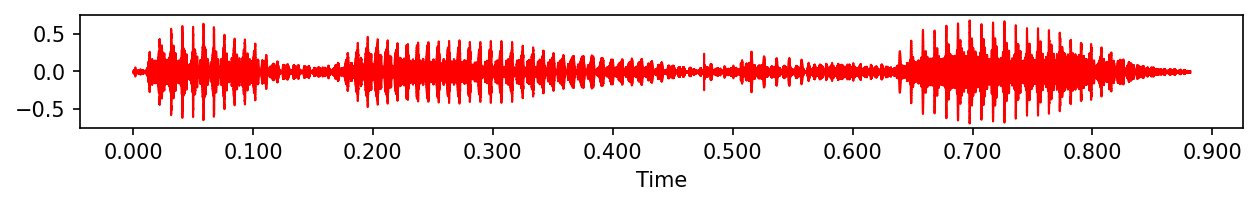

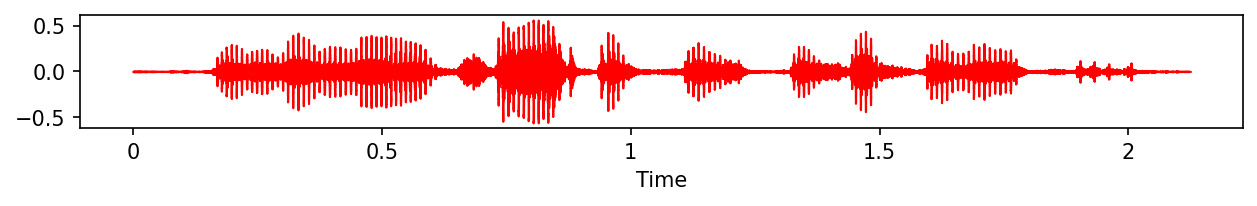

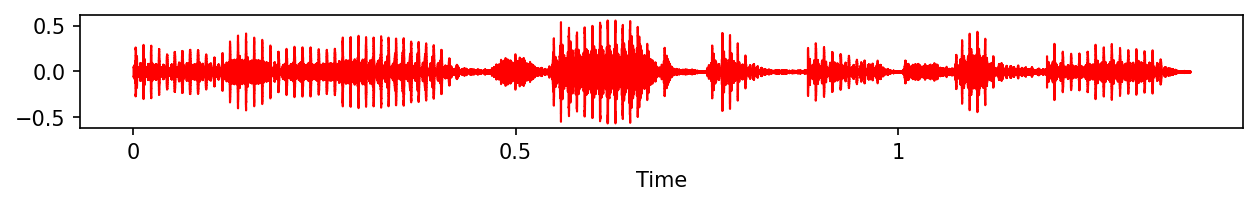

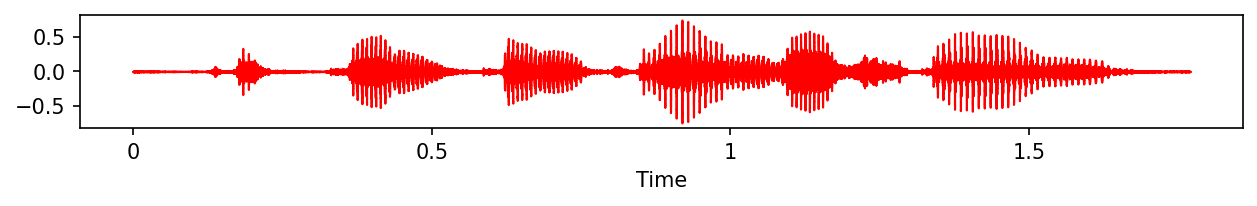

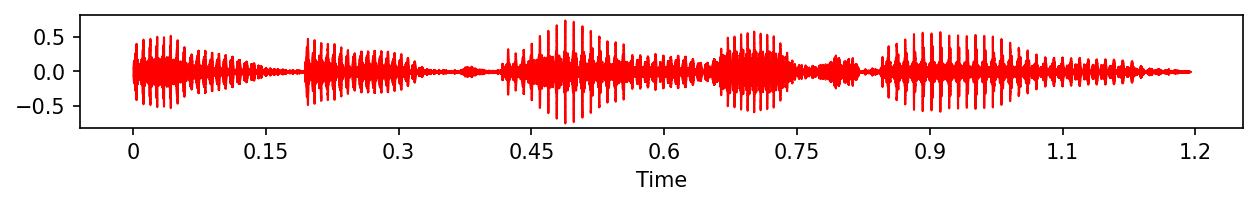

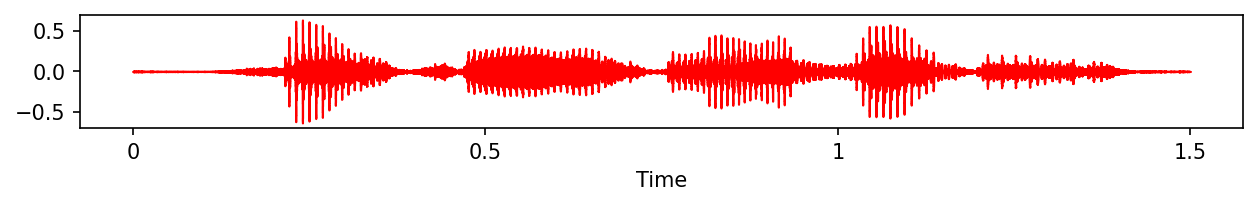

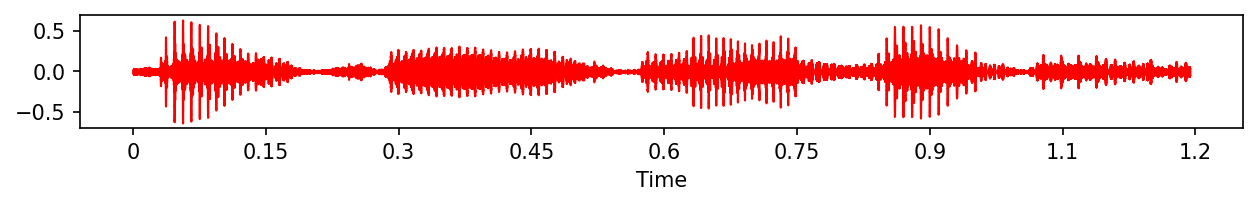

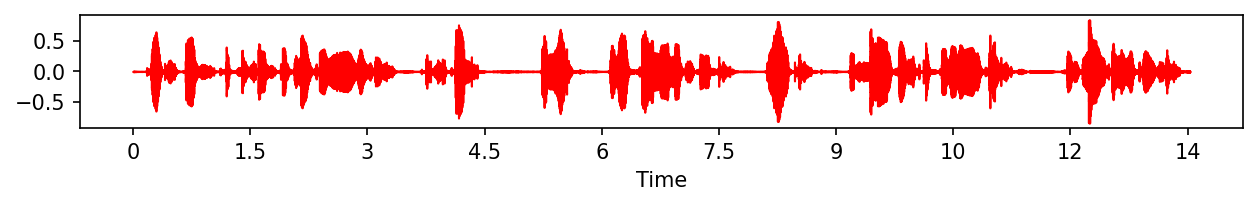

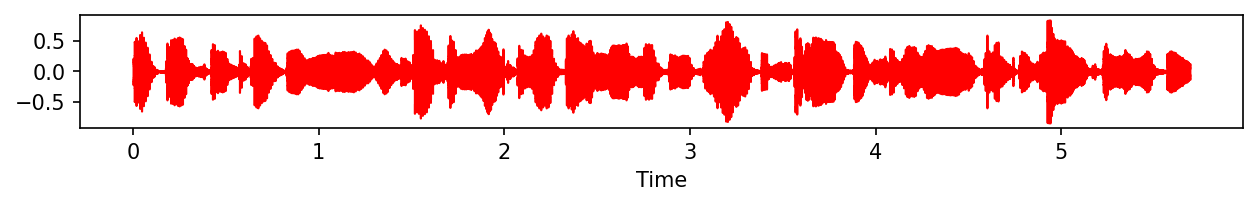

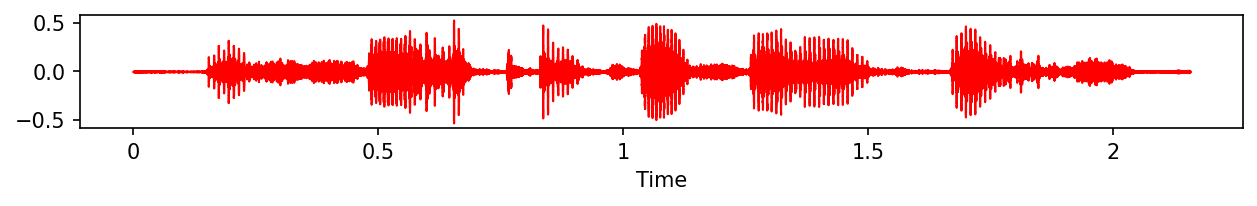

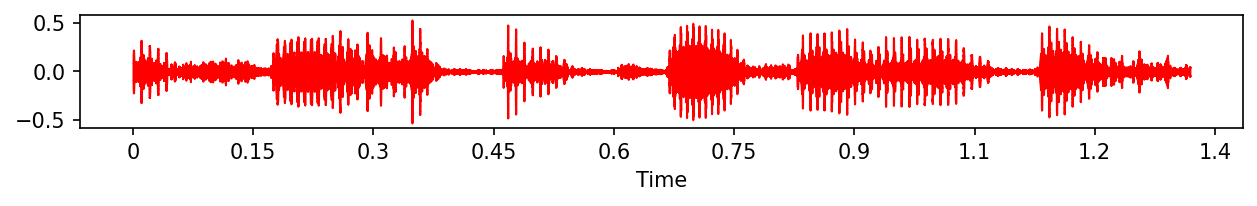

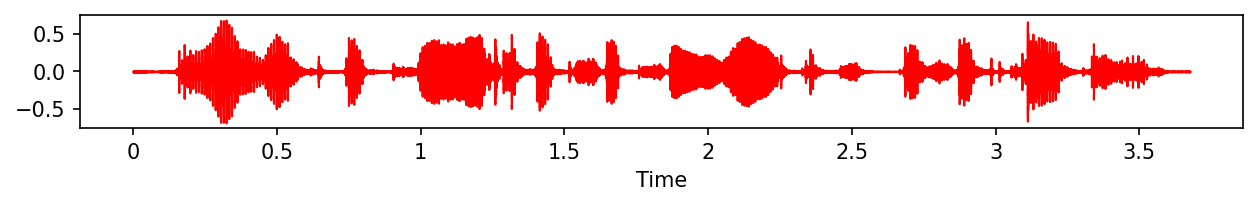

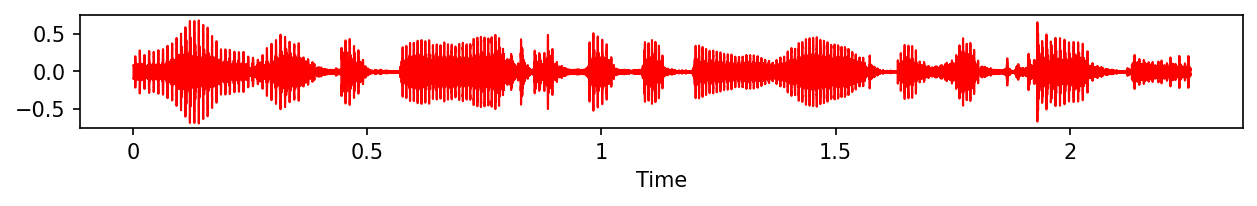

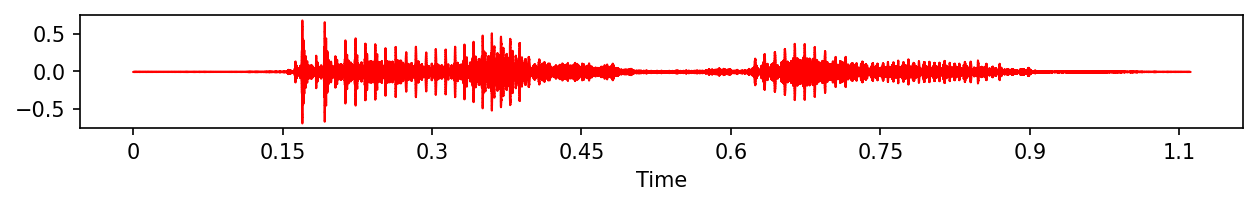

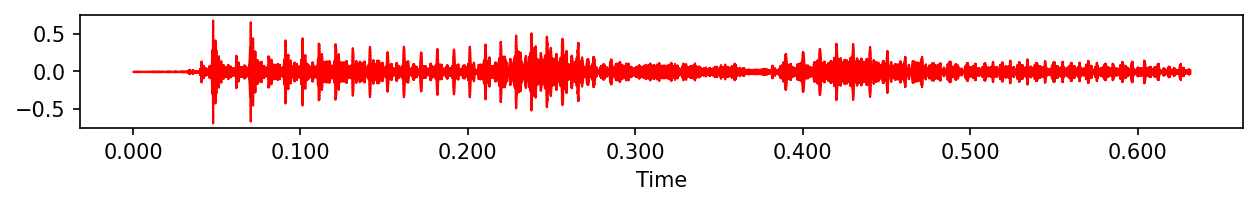

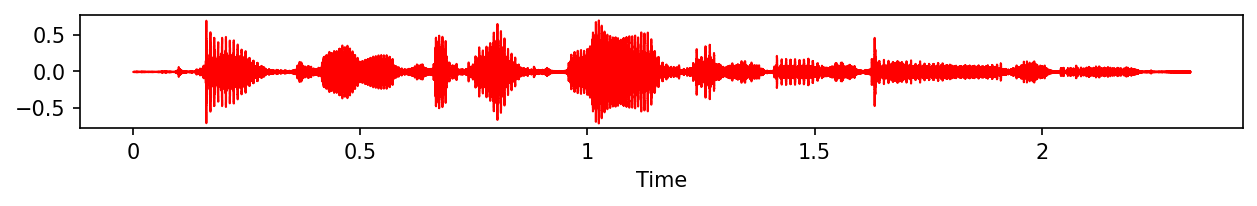

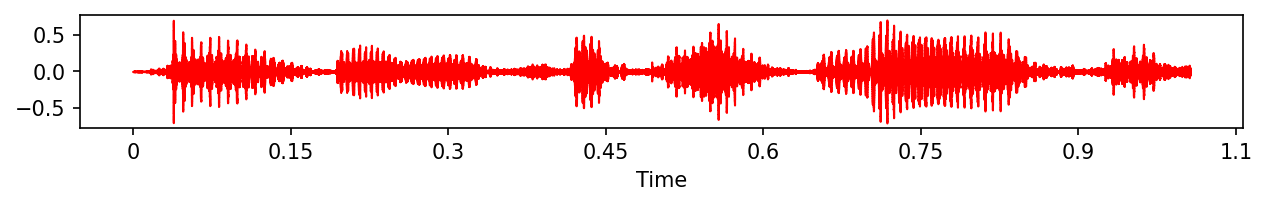

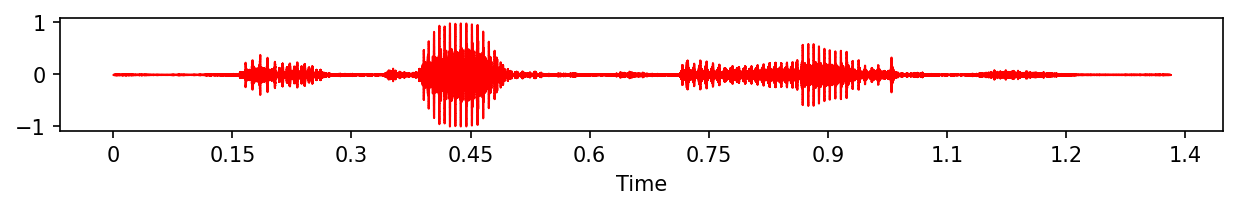

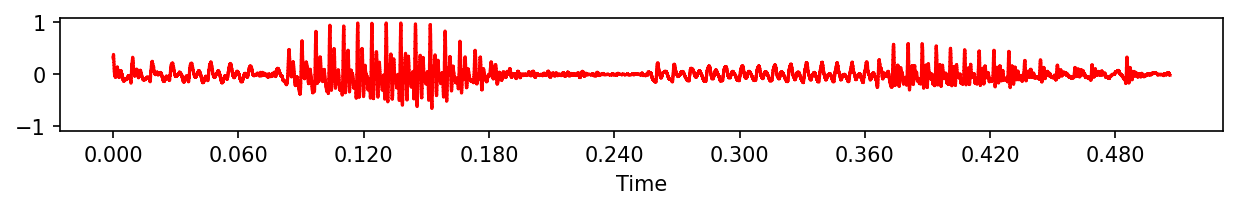

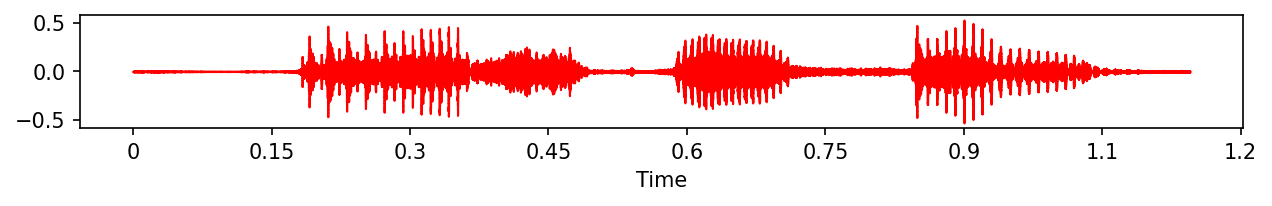

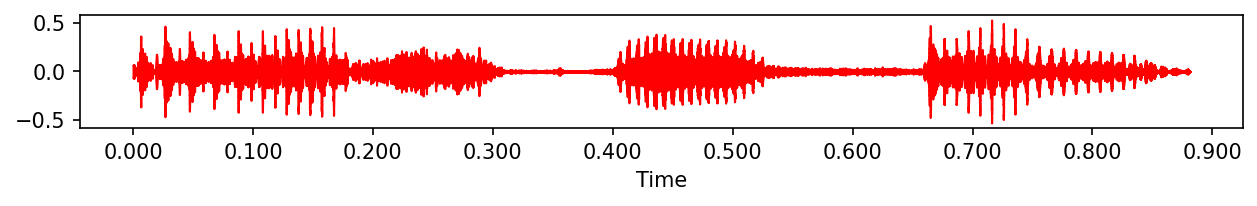

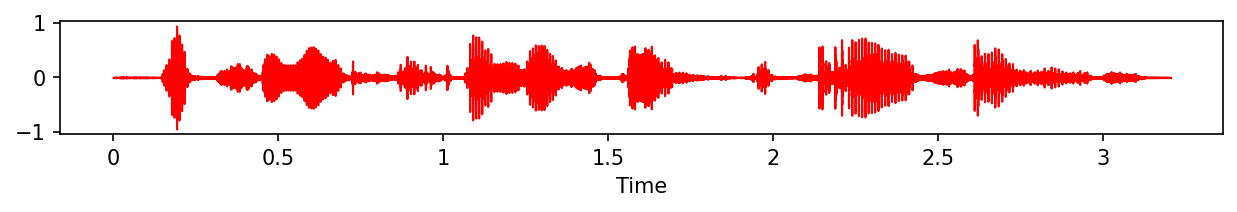

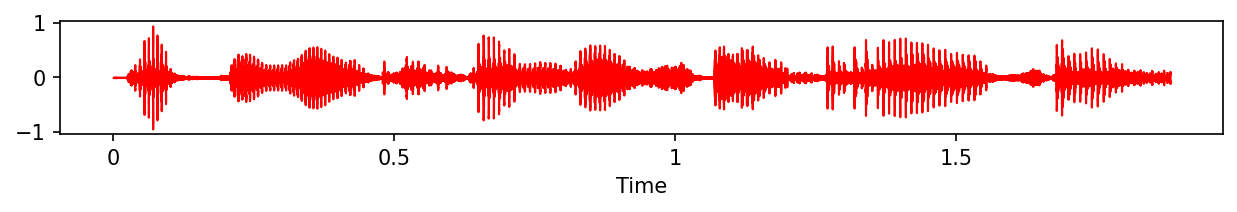

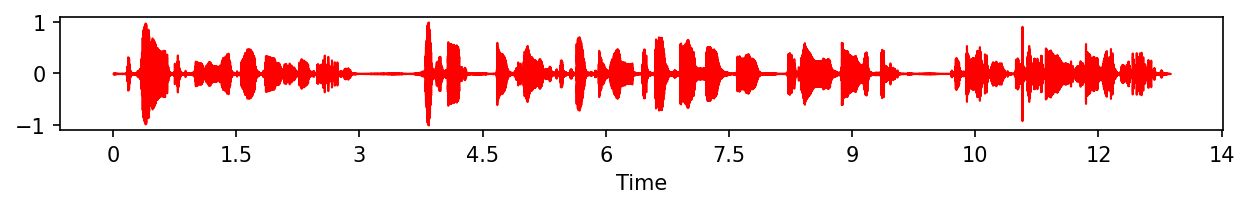

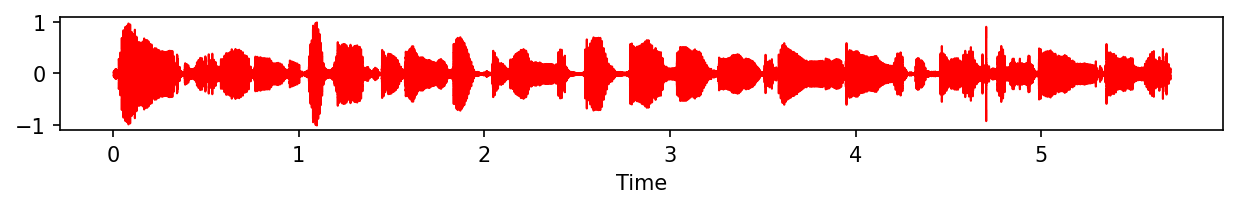

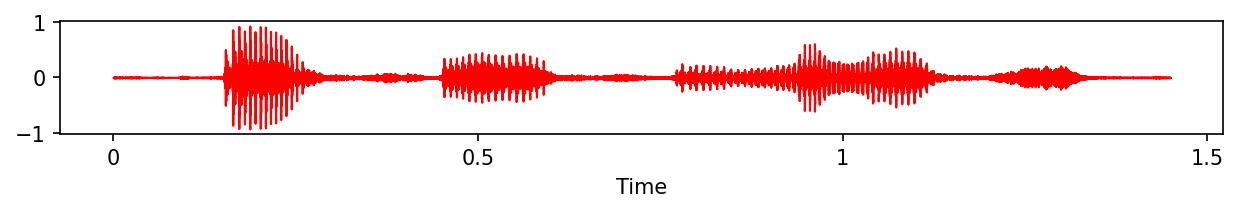

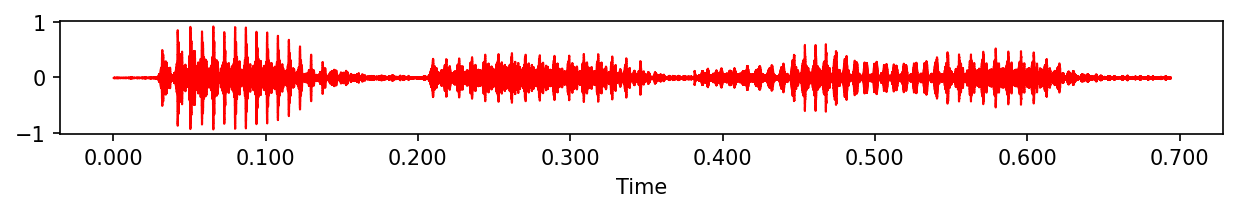

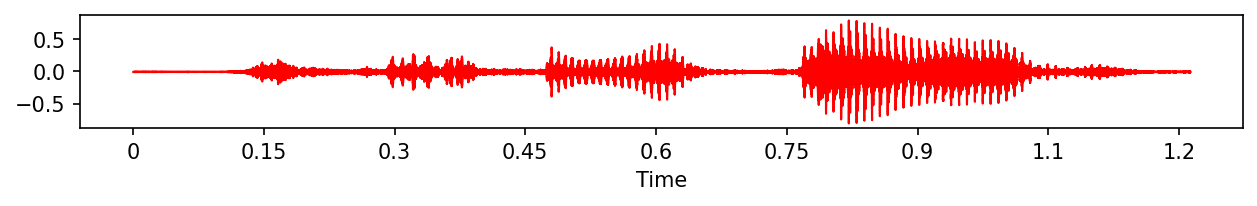

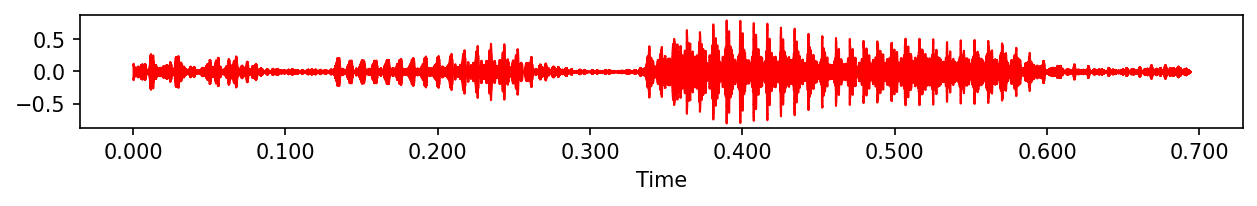

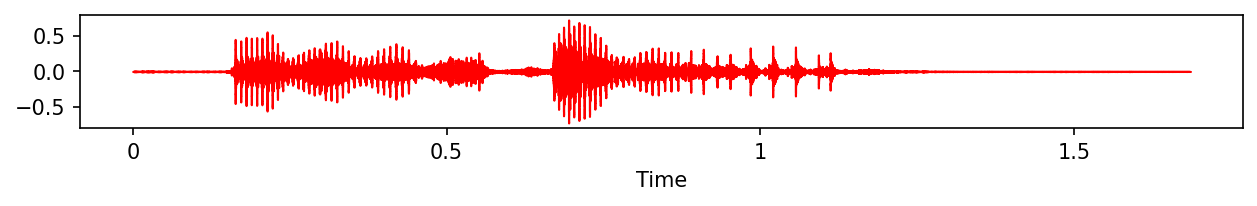

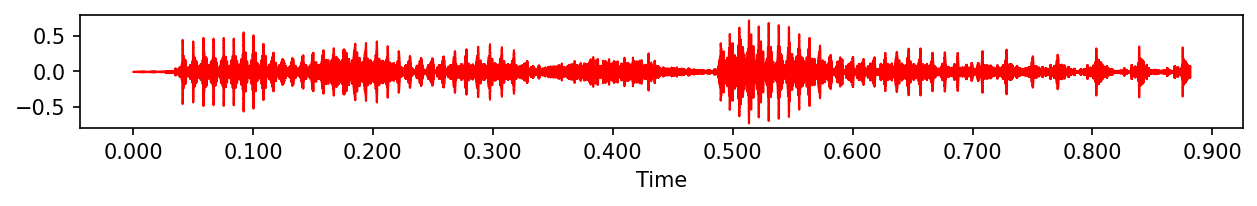

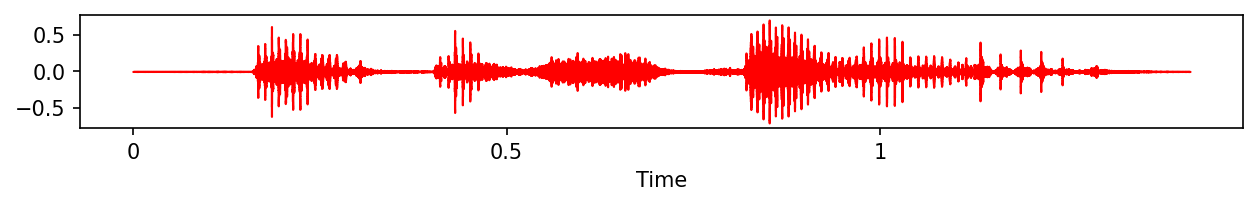

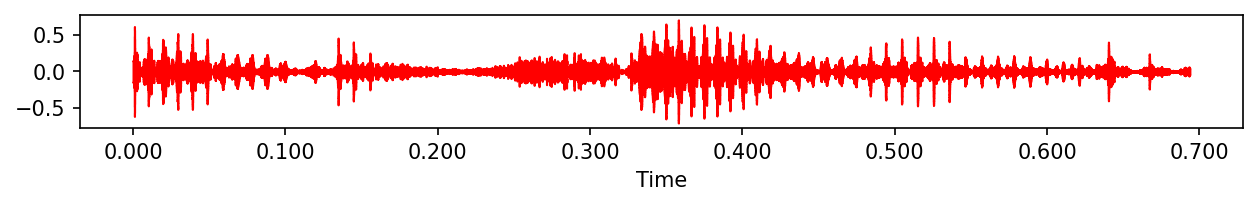

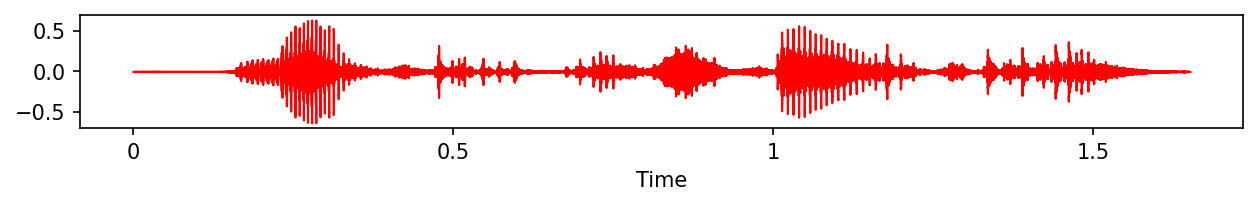

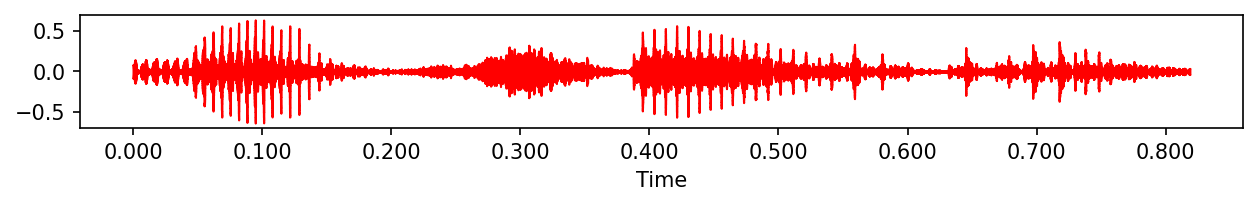

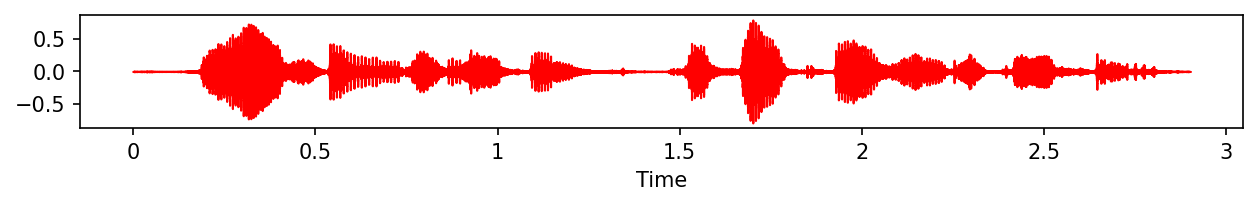

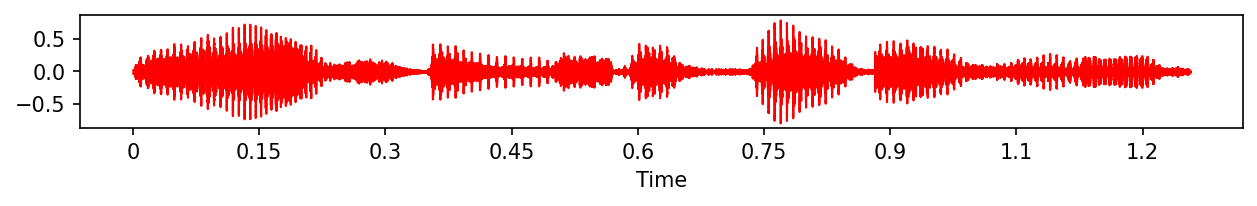

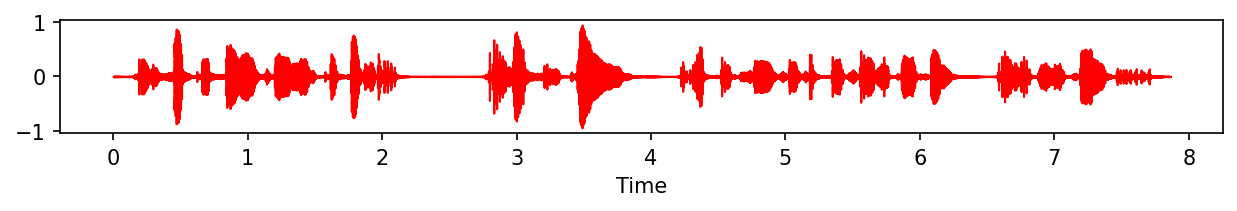

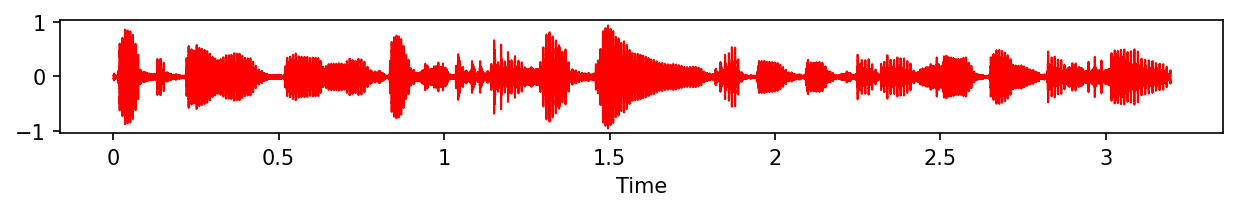

In [17]:
def read_display_audio(uploaded_file):
    st.audio(uploaded_file)
    audio, sr = librosa.load(uploaded_file,sr=16000)
    fig = plt.figure(figsize=(10,1), dpi=150)
    #plt.axis('off')
    #plt.rcParams['axes.facecolor']='none'
    #plt.rcParams['savefig.facecolor']='none'
    waveplot(audio, sr=sr, color="blue")
    st.pyplot(fig)
    return audio, sr

audio_path = "C:\\Users\\mikea\\OneDrive\\Documents\\University\\Third Year\\Thesis\\Code\\audio\\Stephen Hawking.wav"
audio, sr = read_display_audio(audio_path)
dia_df = diarization(audio_path)
transcript_df = generate_transcript_dia(audio, sr, dia_df)
transcript_df

In [39]:
from pyannote.audio.core.io import Audio, AudioFile
from pyannote.core import notebook, Segment, SlidingWindow
from pyannote.core import SlidingWindowFeature as SWF

class RollingAudioBuffer(Audio):
    """Rolling audio buffer
    
    Parameters
    ----------
    sample_rate : int
        Sample rate
    duration : float, optional
        Duration of rolling buffer. Defaults to 5s.
    step : float, optional
        Delay between two updates of the rolling buffer. Defaults to 1s.


    Usage
    -----
    >>> buffer = RollingAudioBuffer()("audio.wav")
    >>> current_buffer = next(buffer)
    """
    def __init__(self, sample_rate=16000, duration=5.0, step=1.):
        super().__init__(sample_rate=sample_rate, mono=True)
        self.duration = duration
        self.step = step
        
    def __call__(self, file: AudioFile):
        
        # duration of the whole audio file
        duration = self.get_duration(file)
        
        # slide a 5s window from the beginning to the end of the file
        window = SlidingWindow(start=0., duration=self.duration, step=self.step, end=duration)
        for chunk in window:
            # for each position of the window, yield the corresponding audio buffer
            # as a SlidingWindowFeature instance
            waveform, sample_rate = self.crop(file, chunk, fixed=self.duration)
            resolution = SlidingWindow(start=chunk.start, 
                                       duration=1./self.sample_rate, 
                                       step=1./sample_rate)
            yield SWF(waveform.T, resolution)

import torch
import numpy as np
from pyannote.audio import Model

class VoiceActivityDetection:
    
    def __init__(self):
        self.model = Model.from_pretrained("pyannote/segmentation")
        self.model.eval()
        
    def __call__(self, current_buffer: SWF) -> SWF:
        
        # we start by applying the model on the current buffer
        with torch.no_grad():
            waveform = current_buffer.data.T
            segmentation = self.model(waveform[np.newaxis]).numpy()[0]

        # temporal resolution of the output of the model
        resolution = self.model.introspection.frames
        
        # temporal shift to keep track of current buffer start time
        resolution = SlidingWindow(start=current_buffer.sliding_window.start, 
                                   duration=resolution.duration, 
                                   step=resolution.step)
            
        # pyannote/segmentation pretrained model actually does more than just voice activity detection
        # see https://huggingface.co/pyannote/segmentation for more details.     
        speech_probability = np.max(segmentation, axis=-1, keepdims=True)
        
        return SWF(speech_probability, resolution)

In [44]:
MY_AUDIO_FILE = "C:\\Users\\mikea\\OneDrive\\Documents\\University\\Third Year\\Thesis\\Code\\audio\\Stephen Hawking.wav"
buffer = RollingAudioBuffer()(MY_AUDIO_FILE)

In [42]:
notebook.crop = Segment(0, 10)

def visualize(features):
    figsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (notebook.width, 2)
    notebook.plot_feature(features)

In [45]:
next(buffer)

TypeError: crop() got an unexpected keyword argument 'fixed'